In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import scipy as sp
import IPython.display as ipd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    LSTM,
    TimeDistributed,
    Reshape,
    Input,
)
from tensorflow.keras.optimizers import Adam


In [2]:
# Step 1: Dataset Paths
MEMBO_PATH = "D:/FYP/Datasets/Github Sourced/DroneAudioDataset-master/DroneAudioDataset-master/Multiclass_Drone_Audio/membo_1"  # Folder for Membo drone
BEBOP_PATH = "D:/FYP/Datasets/Github Sourced/DroneAudioDataset-master/DroneAudioDataset-master/Multiclass_Drone_Audio/bebop_1"  # Folder for Bebop drone
NOISE_PATH = "D:/FYP/Datasets/Github Sourced/DroneAudioDataset-master/DroneAudioDataset-master/Multiclass_Drone_Audio/unknown"  # Folder for random noise


In [3]:
audio_path = 'D:/FYP/Datasets/Github Sourced/DroneAudioDataset-master/DroneAudioDataset-master/Multiclass_Drone_Audio/membo_1/extra_membo_D2_2000.wav'
y , sr = librosa.load(audio_path,sr=None)
ipd.Audio(data=y, rate=sr)

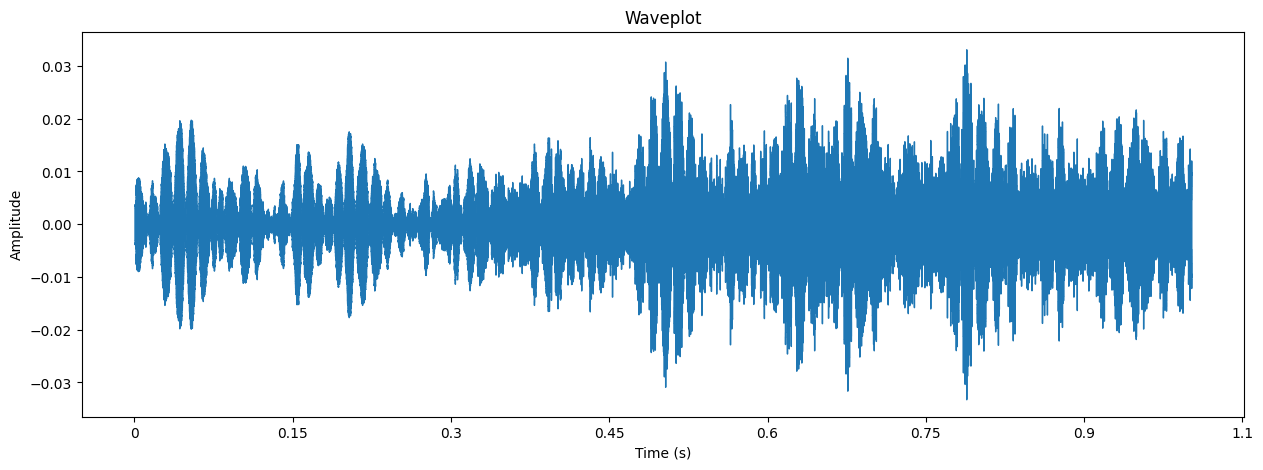

In [4]:
plt.figure(figsize=(15,17))
plt.subplot(3,1,1)
librosa.display.waveshow(y,sr=sr)
plt.title('Waveplot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [5]:
ft = sp.fft.fft(y)
mag = np.absolute(ft)
freq = np.linspace(0,sr,len(mag))

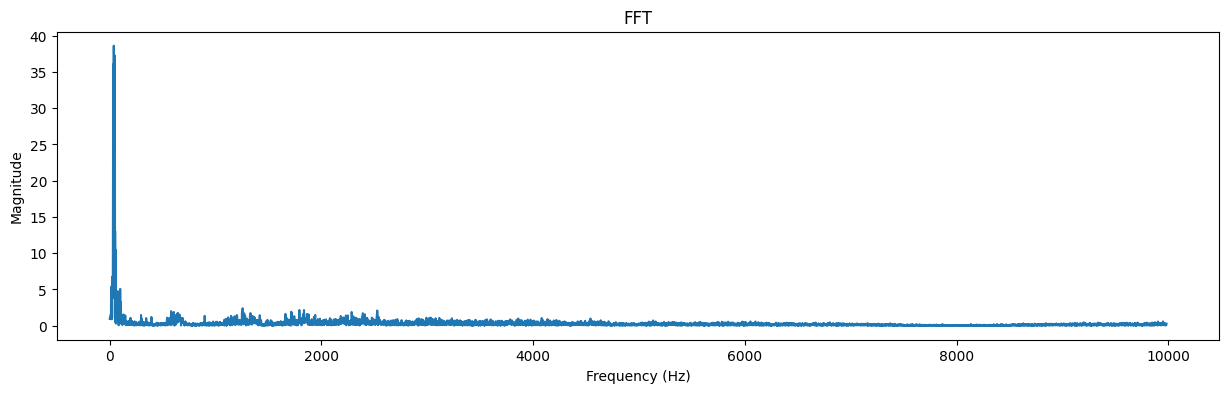

In [6]:
plt.figure(figsize=(15,4))
plt.plot(freq[:10000],mag[:10000])
plt.title('FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

In [7]:
def plot_spectogram(signal,sr,hop_length,y_axis='linear'):
    plt.figure(figsize=(10,5))
    librosa.display.specshow(signal,sr=sr,x_axis='time',y_axis=y_axis,hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectogram')
    plt.show()

In [8]:
Frame_size = 2048
hop_length = 512
S_signal = librosa.stft(y,n_fft=Frame_size,hop_length=hop_length)

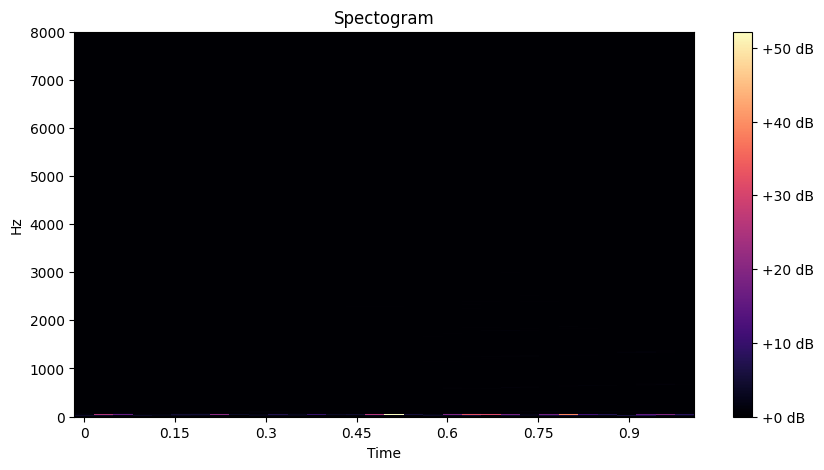

In [9]:
y_signal = np.abs(S_signal)**2
plot_spectogram(y_signal,sr,hop_length)

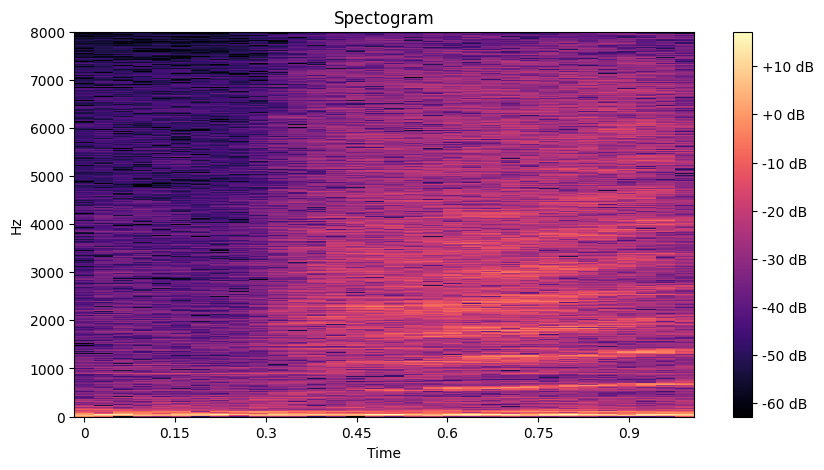

In [10]:
y_signal_log = librosa.power_to_db(y_signal)
y_signal_log.shape
plot_spectogram(y_signal_log,sr,hop_length)

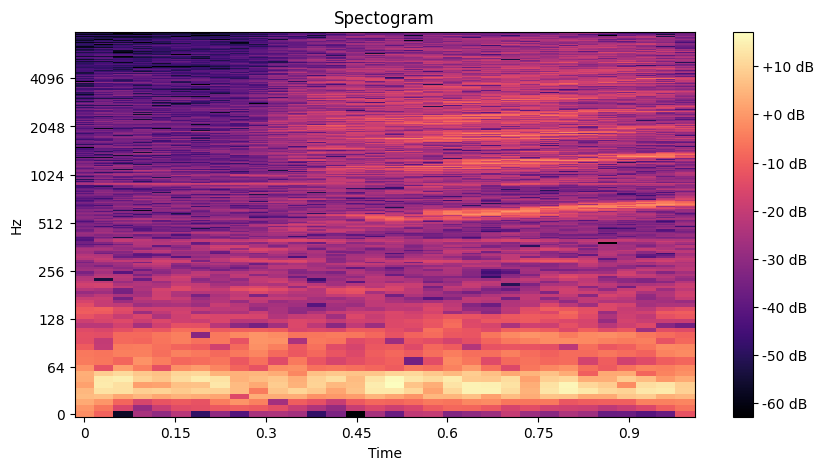

In [11]:
plot_spectogram(y_signal_log,sr,hop_length,y_axis='log')

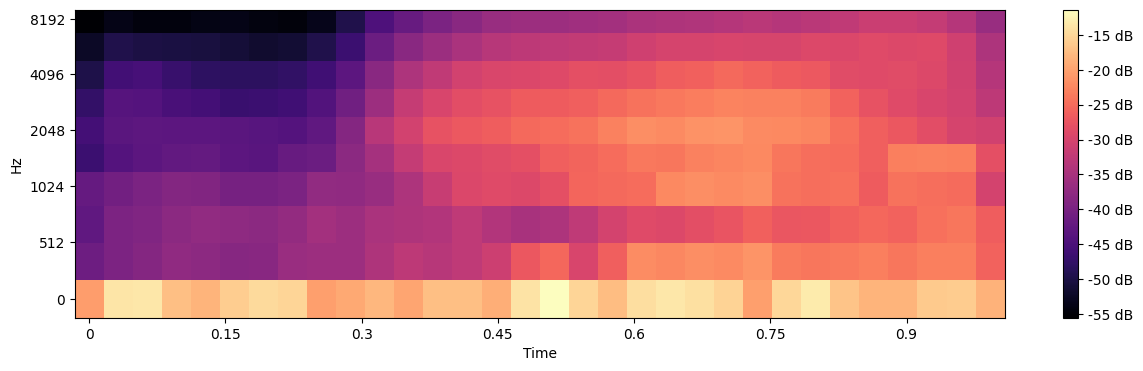

In [12]:
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=10)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
plt.figure(figsize=(15,4))
librosa.display.specshow(log_mel_spectrogram,sr=sr,x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

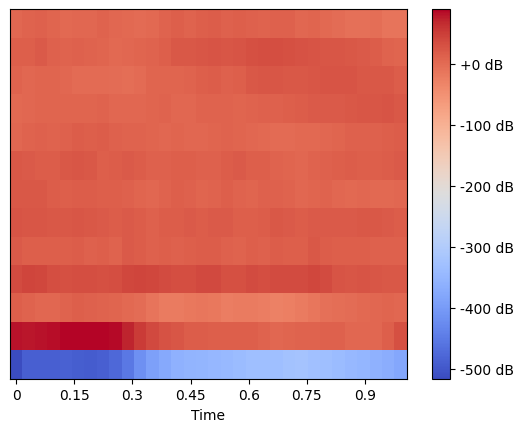

In [13]:
mfccs = librosa.feature.mfcc(y=y, n_mfcc=13, sr=sr)
mfccs.shape
plt.figure.figsize=(25,10)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()

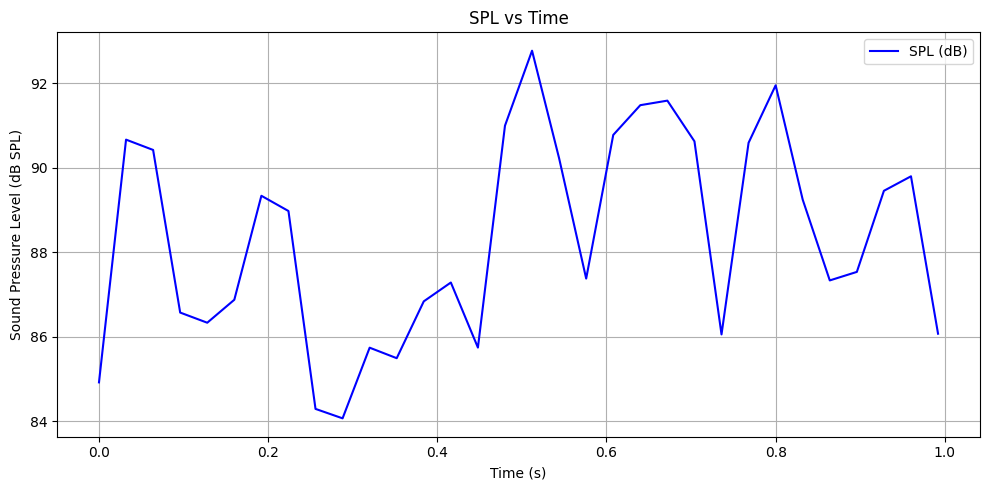

In [14]:
FRAME_LENGTH = 1024                 # Number of samples per frame (~64ms at 16kHz)
HOP_LENGTH = 512                   # Overlap between frames (~50% overlap)
MIC_SENSITIVITY_MV_PA = 22         
V_MAX = 0.98                       # Max voltage input to ADC
BIT_DEPTH = 16
P_REF = 20e-6                      # Reference pressure in air (20 μPa)

# === LOAD AUDIO === #
signal, sr = librosa.load(audio_path, sr=None)

# === CALCULATE RMS === #
rms = librosa.feature.rms(y=signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
times = librosa.times_like(rms, sr=sr, hop_length=HOP_LENGTH)

# === CONVERT RMS TO SPL === #
adc_resolution = 2 ** (BIT_DEPTH - 1)
P_mic_rms = (rms * V_MAX) / (adc_resolution * MIC_SENSITIVITY_MV_PA * 1e-3)
spl = 94 + 20 * np.log10(P_mic_rms / P_REF)

# === PLOT === #
plt.figure(figsize=(10, 5))
plt.plot(times, spl, label="SPL (dB)", color='b')
plt.xlabel("Time (s)")
plt.ylabel("Sound Pressure Level (dB SPL)")
plt.title("SPL vs Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

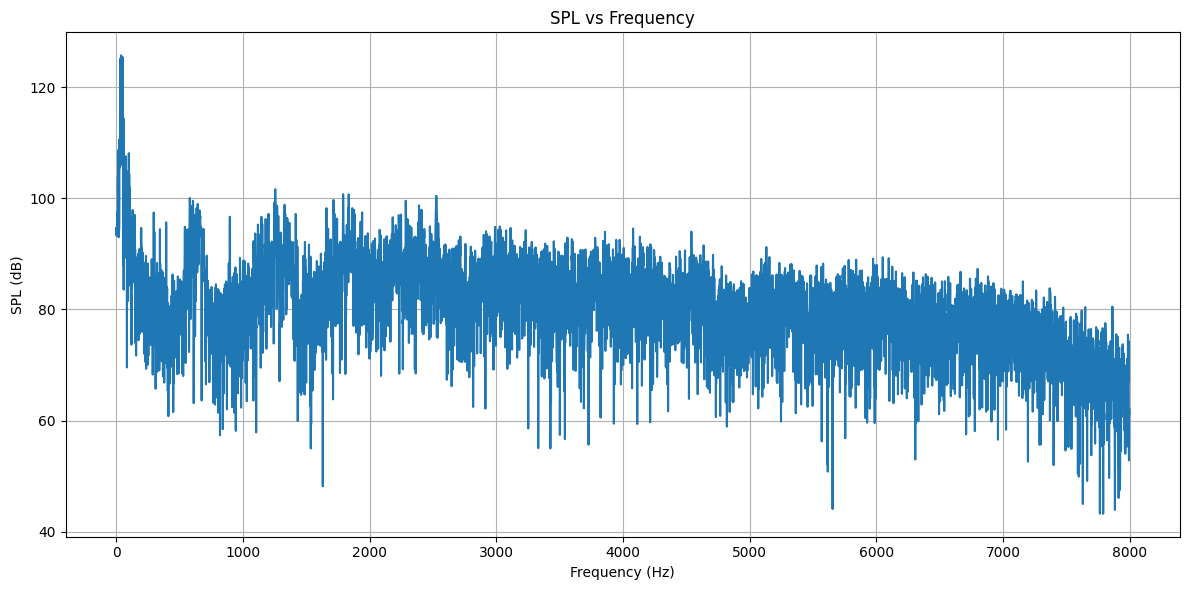

In [15]:
# Compute FFT
N = len(signal)
fft_spectrum = np.fft.fft(signal)
freqs = np.fft.fftfreq(N, d=1/sr)
magnitude = np.abs(fft_spectrum)[:N // 2]  # Take only positive frequencies
freqs = freqs[:N // 2]

# Convert magnitude to SPL (dB)
# Add a small value to avoid log(0)
spl_spectrum = 94 + 20 * np.log10(magnitude + 1e-12)

# Plot SPL vs Frequency
plt.figure(figsize=(12, 6))
plt.plot(freqs, spl_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('SPL (dB)')
plt.title('SPL vs Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Step 2: Helper Functions
def load_audio_files(folder_path, label):
    """Load audio files and associate each with a label."""
    data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            signal, sr = librosa.load(
                file_path, sr=16000
            )  # Load with fixed sampling rate
            data.append((signal, label))
    return data


# Load datasets
membo_data = load_audio_files(MEMBO_PATH, "membo")
bebop_data = load_audio_files(BEBOP_PATH, "bebop")
noise_data = load_audio_files(NOISE_PATH, "noise")

In [17]:
# Combine and shuffle data
data = membo_data + bebop_data + noise_data
np.random.shuffle(data)


# Step 3: Feature Extraction
def extract_features(signal, sr=16000, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    return mfccs.mean(axis=1)  # Averaging over time for traditional ML models


features = []
labels = []

for signal, label in data:
    mfcc_features = extract_features(signal)
    features.append(mfcc_features)
    labels.append(label)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


d:\FYP\Final Project\myenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=24
  warnings.warn(
d:\FYP\Final Project\myenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1266
  warnings.warn(


In [18]:
# Step 5: CNN Model for Audio Spectrograms
def prepare_cnn_data():
    cnn_features = []
    cnn_labels = []
    max_mfcc_length = 40  # Ensure all MFCC arrays have the same time dimension
    
    for signal, label in data:
        # Extract MFCC features
        mfcc_features = librosa.feature.mfcc(y=signal, sr=16000, n_mfcc=13)
        
        # Pad or truncate the features to the fixed length
        if mfcc_features.shape[1] < max_mfcc_length:
            # Pad if shorter
            padding = max_mfcc_length - mfcc_features.shape[1]
            mfcc_features = np.pad(mfcc_features, ((0, 0), (0, padding)), mode='constant')
        else:
            # Truncate if longer
            mfcc_features = mfcc_features[:, :max_mfcc_length]
        
        # Expand dimensions for CNN input
        cnn_features.append(np.expand_dims(mfcc_features, axis=-1))
        cnn_labels.append(label)
        
    return np.array(cnn_features), to_categorical(label_encoder.transform(cnn_labels))


cnn_features, cnn_labels = prepare_cnn_data()
X_train, X_test, y_train, y_test = train_test_split(
    cnn_features, cnn_labels, test_size=0.2, random_state=42
)

cnn_model = Sequential(
    [
        Conv2D(
            32,
            (3, 3),
            activation="relu",
            input_shape=(cnn_features.shape[1], cnn_features.shape[2], 1),
        ),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(len(label_encoder.classes_), activation="softmax"),
    ]
)

cnn_model.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)
cnn_model.fit(
    X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test)
)
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"CNN Test Accuracy: {accuracy}")


d:\FYP\Final Project\myenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=24
  warnings.warn(
d:\FYP\Final Project\myenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1266
  warnings.warn(
d:\FYP\Final Project\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8746 - loss: 1.8513 - val_accuracy: 0.9633 - val_loss: 0.1377
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9547 - loss: 0.1391 - val_accuracy: 0.9761 - val_loss: 0.0920
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9687 - loss: 0.0976 - val_accuracy: 0.9795 - val_loss: 0.0694
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9773 - loss: 0.0711 - val_accuracy: 0.9889 - val_loss: 0.0500
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9748 - loss: 0.0792 - val_accuracy: 0.9816 - val_loss: 0.0585
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9785 - loss: 0.0623 - val_accuracy: 0.9885 - val_loss: 0.0355
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9800 - loss: 0.0539 - val_accuracy: 0.9902 - val_loss: 0.0300
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9820 - loss: 0.0480 - val_accu

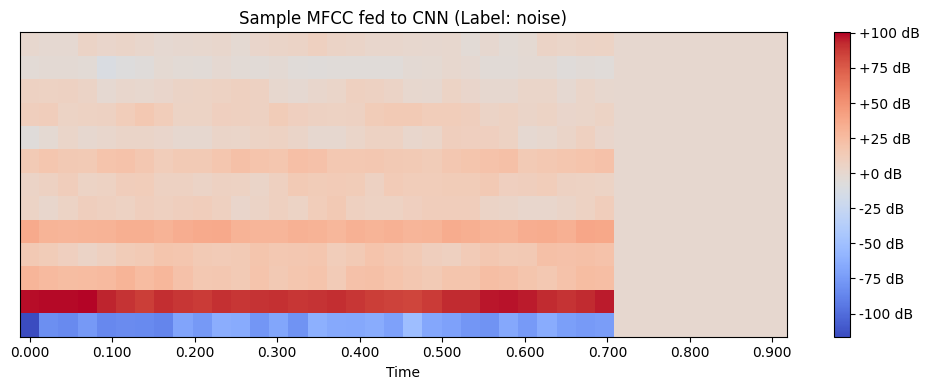

In [19]:
# Pick a sample index (e.g., the first sample)
sample_idx = 0

# Remove the last dimension for plotting (shape: [n_mfcc, time])
sample_mfcc = cnn_features[sample_idx, :, :, 0]

plt.figure(figsize=(10, 4))
librosa.display.specshow(sample_mfcc, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Sample MFCC fed to CNN (Label: {label_encoder.inverse_transform([np.argmax(cnn_labels[sample_idx])])[0]})")
plt.tight_layout()
plt.show()

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


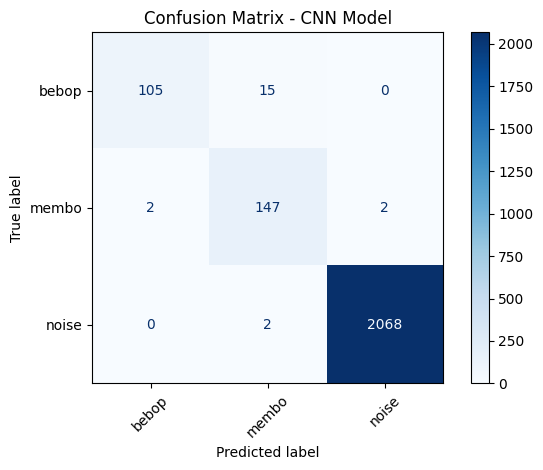

In [20]:
# Step 1: Make predictions on the test set
y_pred_probs = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = label_encoder.classes_

# Step 3: Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - CNN Model")
plt.tight_layout()
plt.show()

In [21]:


# Step 6: RNN Model
def prepare_rnn_data():
    rnn_features = []
    rnn_labels = []
    max_mfcc_length = 40  # Define a fixed length for MFCC time steps

    for signal, label in data:
        # Extract MFCC features
        mfcc_features = librosa.feature.mfcc(y=signal, sr=16000, n_mfcc=13)
        
        # Pad or truncate to the fixed length
        if mfcc_features.shape[1] < max_mfcc_length:
            pad_width = max_mfcc_length - mfcc_features.shape[1]
            mfcc_features = np.pad(mfcc_features, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc_features = mfcc_features[:, :max_mfcc_length]
        
        rnn_features.append(mfcc_features.T)  # Transpose for time-series input
        rnn_labels.append(label)

    return np.array(rnn_features), to_categorical(label_encoder.transform(rnn_labels))



rnn_features, rnn_labels = prepare_rnn_data()
X_train, X_test, y_train, y_test = train_test_split(
    rnn_features, rnn_labels, test_size=0.2, random_state=42
)

rnn_model = Sequential(
    [
        LSTM(
            64,
            return_sequences=False,
            input_shape=(rnn_features.shape[1], rnn_features.shape[2]),
        ),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(len(label_encoder.classes_), activation="softmax"),
    ]
)

rnn_model.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)
rnn_model.fit(
    X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test)
)
loss, accuracy = rnn_model.evaluate(X_test, y_test)
print(f"RNN Test Accuracy: {accuracy}")

d:\FYP\Final Project\myenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=24
  warnings.warn(
d:\FYP\Final Project\myenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1266
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Scale features for SVM
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 4: SVM Model
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, encoded_labels, test_size=0.2, random_state=42
)

svm_model = SVC(kernel="rbf", probability=True)
svm_model.fit(X_train, y_train)
svm_accuracy = svm_model.score(X_test, y_test)
print(f"SVM Test Accuracy: {svm_accuracy}")


ValueError: Found input variables with inconsistent numbers of samples: [11704, 3]

In [ ]:



# Step 7: CRNN Model
input_layer = Input(shape=(rnn_features.shape[1], rnn_features.shape[2]))
x = Reshape((rnn_features.shape[1], rnn_features.shape[2], 1))(input_layer)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(64)(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
output_layer = Dense(len(label_encoder.classes_), activation="softmax")(x)

crnn_model = Model(inputs=input_layer, outputs=output_layer)
crnn_model.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)
crnn_model.fit(
    X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test)
)
loss, accuracy = crnn_model.evaluate(X_test, y_test)
print(f"CRNN Test Accuracy: {accuracy}")


Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.9061 - loss: 0.3293 - val_accuracy: 0.9671 - val_loss: 0.1109
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9617 - loss: 0.1155 - val_accuracy: 0.9722 - val_loss: 0.0765
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9726 - loss: 0.0791 - val_accuracy: 0.9752 - val_loss: 0.0652
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9783 - loss: 0.0648 - val_accuracy: 0.9846 - val_loss: 0.0485
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9850 - loss: 0.0476 - val_accuracy: 0.9906 - val_loss: 0.0299
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9869 - loss: 0.0363 - val_accuracy: 0.9932 - val_loss: 0.0188
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9919 - loss: 0.0239 - val_accuracy: 0.9932 - val_loss: 0.0179
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9946 - loss: 0.0141 - val_acc